In [1]:
import logging
import os
import random
import time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from PIL import Image
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from collab.utils import find_repo_root

root = find_repo_root()
from collab.foraging import random_hungry_followers as rhf
from collab.foraging import toolkit as ft

logging.basicConfig(format="%(message)s", level=logging.INFO)


smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000


notebook_starts = time.time()

## Random foragers

To ease imagination, suppose foragers are foragers that move randomly with some probabilistic preference for the distance at which they move, 
but no reasons to move otherwise. 

### Running a simulation

In [2]:
random.seed(22)
np.random.seed(22)

random_foragers_sim = rhf.RandomForagers(
    grid_size=40,
    probabilities=[1, 2, 3, 2, 1, 2, 3, 2, 1],
    num_foragers=3,
    num_frames=num_frames,
    num_rewards=15,
    grab_range=3,
)

# run a particular simulation with these parameters
random_foragers_sim()

# you have created foragers and rewards in a space-time grid
# each row contains the x and y coordinates of a forager at a particular time

random_foragers_sim.foragersDF.head()

x     y  time  forager    type
0  18.0  18.0     1        1  random
1  18.0  16.0     2        1  random
2  17.0  18.0     3        1  random
3  20.0  16.0     4        1  random
4  17.0  18.0     5        1  random

In [3]:
# look at just the foragers

ft.animate_foragers(
    random_foragers_sim, plot_rewards=True, width=600, height=600, point_size=6
)

### Derived predictors

In [4]:
# add derived predictors to the simulation object

random_foragers_derived = ft.derive_predictors(random_foragers_sim, dropna=False)

2023-12-19 06:23:58,690 - traces done
2023-12-19 06:23:58,718 - visibility done
2023-12-19 06:23:58,752 - proximity done
2023-12-19 06:23:58,764 - how_far done
2023-12-19 06:23:58,771 - derivedDF done
2023-12-19 06:23:58,772 - starting to generate communicates
2023-12-19 06:23:58,810 - communicates done


In [5]:
# now we can plot food traces in time:

ft.animate_foragers(
    random_foragers_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_traces=True,
)

In [6]:
# this exports and crops frame 0
if not smoke_test:
    trace_anim = ft.animate_foragers(
        random_foragers_derived,
        plot_rewards=True,
        width=600,
        height=600,
        point_size=10,
        plot_traces=True,
        produce_object=True,
    )

    trace_frame3 = go.Figure(trace_anim.frames[0].data, trace_anim.layout)
    trace_frame3.update_layout(title_text="food traces")

    pio.write_image(
        trace_frame3,
        os.path.join(root, "docs/figures/fig2_trace.png"),
        engine="kaleido",
        width=600,
        height=600,
        scale=5,
    )

    trace_frame3_image = Image.open(os.path.join(root, "docs/figures/fig2_trace.png"))
    trace_frame3_cropped = trace_frame3_image.crop((600, 250, 3050, 2000))
    trace_frame3_cropped.save(os.path.join(root, "docs/figures/fig2_trace_cropped.png"))

In [7]:
# we can also plot visibility, for one forager at a time
# as multiple foragergers' visibility is hard to see
# let's say, forager 2

ft.animate_foragers(
    random_foragers_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_visibility=2,
    plot_traces=True,
)

In [8]:
# we can plot proximity score
# forager 2 again

ft.animate_foragers(
    random_foragers_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_proximity=2,
    proximity_multiplier=25,
)

In [9]:
# this exports and crops frame 3
prox_anim = ft.animate_foragers(
    random_foragers_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_proximity=2,
    proximity_multiplier=25,
    produce_object=True,
)

prox_frame3 = go.Figure(prox_anim.frames[0].data, prox_anim.layout)
prox_frame3.update_layout(title_text="Proximity scores (forager 2)")

pio.write_image(
    prox_frame3,
    os.path.join(root, "docs/figures/fig2_proximity.png"),
    engine="kaleido",
    width=600,
    height=600,
    scale=5,
)

prox_frame3_image = Image.open(os.path.join(root, "docs/figures/fig2_proximity.png"))
prox_frame3_cropped = prox_frame3_image.crop((600, 250, 3050, 2000))
prox_frame3_cropped.save(os.path.join(root, "docs/figures/fig2_proximity_cropped.png"))

### Inference


In [10]:
def prep_data_for_inference(sim_derived):
    df = sim_derived.derivedDF[
        [
            "proximity_standardized",
            "trace_standardized",
            "visibility",
            "how_far_squared_scaled",
        ]
    ]

    df.dropna(inplace=True)

    for column in df.columns:
        df[column] = ft.normalize(df[column])

    data = torch.tensor(df.values, dtype=torch.float32)

    proximity, trace, visibility, how_far = (
        data[:, 0],
        data[:, 1],
        data[:, 2],
        data[:, 3],
    )

    print(
        str(len(proximity))
        + " data points prepared for inference, dropped "
        + str(len(sim_derived.derivedDF) - len(proximity))
        + " rows with missing values."
    )
    return proximity, trace, visibility, how_far

In [11]:
proximity, trace, visibility, how_far_score = prep_data_for_inference(
    random_foragers_derived
)

3804 data points prepared for inference, dropped 951 rows with missing values.


In [12]:
ft.visualise_forager_predictors(trace, proximity, how_far_score)

In [13]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(
            percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
        ).transpose()
        site_stats[site_name] = describe[
            ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
        ]
    return site_stats

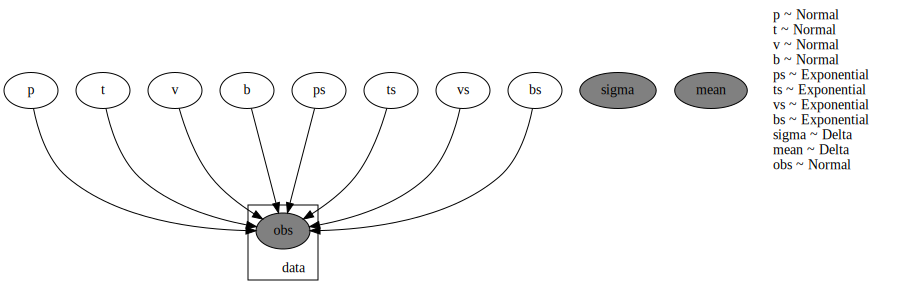

In [14]:
# define the model
# p, t, v, b are the coefficients
# for proximity, trace, visibility, and the intercept

# ps, ts, vs, bs are analogous coefficients,
# but they contribute to the variance,
# which is not assumed to remain fixed


def model_sigmavar(proximity, trace, visibility, how_far_score):
    p = pyro.sample("p", dist.Normal(0, 0.2))
    t = pyro.sample("t", dist.Normal(0, 0.2))
    v = pyro.sample("v", dist.Normal(0, 0.2))
    b = pyro.sample("b", dist.Normal(0.5, 0.3))

    ps = pyro.sample("ps", dist.Exponential(7))
    ts = pyro.sample("ts", dist.Exponential(7))
    vs = pyro.sample("vs", dist.Exponential(7))
    bs = pyro.sample("bs", dist.Exponential(7))

    sigma = pyro.deterministic(
        "sigma", bs + ps * proximity + ts * trace + vs * visibility
    )
    mean = pyro.deterministic("mean", b + p * proximity + t * trace + v * visibility)

    with pyro.plate("data", len(how_far_score)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=how_far_score)


pyro.render_model(
    model_sigmavar,
    model_args=(proximity, trace, visibility, how_far_score),
    render_distributions=True,
)

In [15]:
def summary(samples, sites):
    site_stats = {}
    for site_name, values in samples.items():
        if site_name in sites:
            marginal_site = pd.DataFrame(values)
            describe = marginal_site.describe(
                percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
            ).transpose()
            site_stats[site_name] = describe[
                ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
            ]
    return site_stats


def get_samples(
    proximity,
    trace,
    visibility,
    how_far_score,
    model=model_sigmavar,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model_sigmavar, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(proximity, trace, visibility, how_far_score)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Elbo loss: {}".format(elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    fig = px.line(x=iterations, y=losses, title="ELBO loss", template="presentation")
    labels = {"iterations": "iteration", "losses": "loss"}
    fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
    fig.update_yaxes(showgrid=False, title_text=labels["losses"])
    fig.update_layout(width=700)
    fig.show()

    predictive = Predictive(
        model, guide=guide, num_samples=num_samples, return_sites=["t", "p", "v"]
    )
    rhf_svi = {
        k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
        for k, v in predictive(proximity, trace, visibility, how_far_score).items()
        if k != "obs"
    }

    print("SVI-based coefficient marginals:")
    for site, values in summary(rhf_svi, ["t", "p", "v"]).items():
        print("Site: {}".format(site))
        print(values, "\n")

    return {"svi_samples": rhf_svi, "svi_guide": guide, "svi_predictive": predictive}

In [16]:
samples_random = get_samples(proximity, trace, visibility, how_far_score)

2023-12-19 06:24:01,244 - Starting SVI inference with 10 iterations.


2023-12-19 06:24:01,414 - Elbo loss: 1169.1092666387558
2023-12-19 06:24:01,483 - SVI inference completed in 0.24 seconds.


SVI-based coefficient marginals:
Site: p
      mean       std        5%       25%       50%       75%       95%
0  0.09426  0.104617 -0.039624  0.023802  0.083878  0.176179  0.234205 

Site: t
       mean       std       5%       25%      50%       75%       95%
0  0.120554  0.108688 -0.01782  0.055844  0.11496  0.143878  0.295158 

Site: v
       mean       std        5%       25%       50%       75%       95%
0  0.060594  0.121444 -0.085042 -0.009654  0.042014  0.101644  0.251259 



In [17]:
def plot_coefs(samples, title, ann_start_y=100, ann_break_y=50):
    for key in samples["svi_samples"].keys():
        samples["svi_samples"][key] = samples["svi_samples"][key].flatten()

    samplesDF = pd.DataFrame(samples["svi_samples"])
    samplesDF_medians = samplesDF.median(axis=0)

    fig_coefs = px.histogram(
        samplesDF,
        template="presentation",
        opacity=0.4,
        labels={"variable": "coefficient"},
        width=700,
        title=title,
        marginal="rug",
        barmode="overlay",
    )

    for i, color in enumerate(["#1f77b4", "#ff7f0e"]):
        fig_coefs.add_vline(
            x=samplesDF_medians.iloc[i],
            line_dash="dash",
            line_color=color,
            name=f"Median ({samplesDF_medians.iloc[i]})",
        )

    fig_coefs.add_annotation(
        x=samplesDF_medians.iloc[i],
        y=ann_start_y + ann_break_y * i,  # Adjust the vertical position of the label
        text=f"{samplesDF_medians.iloc[i]:.2f}",
        showarrow=False,
        bordercolor="black",
        borderwidth=2,
        bgcolor="white",
        opacity=0.8,
    )

    fig_coefs.update_traces(marker=dict(line=dict(width=2, color="Black")))

    fig_coefs.show()

In [18]:
plot_coefs(samples_random, "Random foragers", ann_start_y=160, ann_break_y=10)

In [19]:
def calculate_R_squared(guide):
    predictive = pyro.infer.Predictive(model_sigmavar, guide=guide, num_samples=1000)
    predictions = predictive(proximity, trace, visibility, how_far_score)

    simulated_outcome = (
        predictions["b"]
        + predictions["p"] * proximity
        + predictions["t"] * trace
        + predictions["v"] * visibility
    )

    mean_sim_outcome = simulated_outcome.mean(0).detach().cpu().numpy()

    observed_mean = torch.mean(how_far_score)

    tss = torch.sum((how_far_score - observed_mean) ** 2)
    rss = torch.sum((how_far_score - mean_sim_outcome) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()

In [20]:
print("R squared:", calculate_R_squared(samples_random["svi_guide"]))

R squared: 0.1722821593284607


## Hungry birds

In [21]:
# we use a bit more frames,
# a larger grid,
# and more rewards,
# simulation might take a bit longer
hungry_sim = rhf.Foragers(
    grid_size=60, num_foragers=3, num_frames=num_frames, num_rewards=60, grab_range=3
)

hungry_sim()

hungry_sim = rhf.add_hungry_foragers(
    hungry_sim, num_hungry_foragers=3, rewards_decay=0.3, visibility_range=6
)

In [22]:
ft.animate_foragers(
    hungry_sim,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_traces=False,
)

In [23]:
# adding derived predictors
hungry_sim_derived = ft.derive_predictors(hungry_sim, dropna=False)

# plot with trace
# bird 2 again
ft.animate_foragers(
    hungry_sim_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_traces=True,
    trace_multiplier=7,
)

2023-12-19 06:24:04,619 - traces done
2023-12-19 06:24:04,655 - visibility done
2023-12-19 06:24:04,691 - proximity done
2023-12-19 06:24:04,708 - how_far done
2023-12-19 06:24:04,728 - derivedDF done
2023-12-19 06:24:04,729 - starting to generate communicates
2023-12-19 06:24:04,799 - communicates done


In [24]:
# now proximity
ft.animate_foragers(
    hungry_sim_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_proximity=1,
)

In [25]:
proximity, trace, visibility, how_far_score = prep_data_for_inference(
    hungry_sim_derived
)

3804 data points prepared for inference, dropped 951 rows with missing values.


In [26]:
# notice how higher trace points
# are closer to 1

ft.visualise_forager_predictors(trace, proximity, how_far_score)

In [27]:
samples_hungry = get_samples(proximity, trace, visibility, how_far_score)

2023-12-19 06:24:05,358 - Starting SVI inference with 10 iterations.
2023-12-19 06:24:05,389 - Elbo loss: 765.5951114296913
2023-12-19 06:24:05,516 - SVI inference completed in 0.16 seconds.


SVI-based coefficient marginals:
Site: p
       mean       std        5%       25%       50%       75%      95%
0  0.069282  0.086606 -0.034202  0.006234  0.059219  0.120764  0.19545 

Site: t
       mean       std        5%       25%       50%       75%       95%
0  0.068048  0.083433 -0.062088  0.011101  0.098172  0.128148  0.155269 

Site: v
       mean       std        5%       25%       50%       75%       95%
0  0.099246  0.082198 -0.012984  0.056062  0.097875  0.135222  0.222551 



In [28]:
plot_coefs(samples_hungry, "Hungry foragers", ann_start_y=160, ann_break_y=10)

In [29]:
print("R squared:", calculate_R_squared(samples_hungry["svi_guide"]))

R squared: 0.11780858039855957


## Follower birds


In [30]:
follower_sim = rhf.Foragers(
    grid_size=60, num_foragers=3, num_frames=num_frames, num_rewards=30, grab_range=3
)
follower_sim()

random.seed(42)
follower_sim = rhf.add_follower_foragers(
    follower_sim,
    num_follower_foragers=3,
    visibility_range=6,
    getting_worse=0.5,
    optimal=3,
)

follower_sim_derived = ft.derive_predictors(
    follower_sim, getting_worse=0.5, optimal=3, visibility_range=6, dropna=False
)

2023-12-19 06:24:07,539 - traces done
2023-12-19 06:24:07,566 - visibility done
2023-12-19 06:24:07,598 - proximity done
2023-12-19 06:24:07,608 - how_far done
2023-12-19 06:24:07,616 - derivedDF done
2023-12-19 06:24:07,617 - starting to generate communicates
2023-12-19 06:24:07,655 - communicates done


In [31]:
ft.animate_foragers(
    follower_sim_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_proximity=2,
)

In [32]:
proximity, trace, visibility, how_far_score = prep_data_for_inference(
    follower_sim_derived
)

1356 data points prepared for inference, dropped 339 rows with missing values.


In [33]:
# now note how points get closer to 1
# as proximity increases
ft.visualise_forager_predictors(trace, proximity, how_far_score)

In [34]:
samples_followers = get_samples(proximity, trace, visibility, how_far_score)

2023-12-19 06:24:07,870 - Starting SVI inference with 10 iterations.
2023-12-19 06:24:07,883 - Elbo loss: 568.287564098835
2023-12-19 06:24:07,958 - SVI inference completed in 0.09 seconds.


SVI-based coefficient marginals:
Site: p
       mean       std        5%       25%       50%       75%       95%
0  0.103129  0.059222  0.022101  0.058775  0.117887  0.137908  0.180047 

Site: t
       mean       std        5%       25%       50%       75%       95%
0  0.024461  0.096967 -0.048761 -0.027529 -0.008034  0.018574  0.196938 

Site: v
       mean       std        5%       25%      50%       75%       95%
0  0.044656  0.082019 -0.033788 -0.022565  0.01737  0.086888  0.173615 



In [35]:
plot_coefs(samples_followers, "Follower foragers", ann_start_y=160, ann_break_y=10)

In [36]:
print("R squared:", calculate_R_squared(samples_followers["svi_guide"]))

R squared: -0.2876812219619751


In [37]:
def plot_all_coefficients(
    svi_samples, groups, title, xrange, yrange, generate_object=False
):
    data = {"p": [], "t": [], "inference_method": [], "group": []}

    for i, svi_sample in enumerate(svi_samples):
        site_p_svi = svi_sample["p"].flatten().tolist()
        site_t_svi = svi_sample["t"].flatten().tolist()
        data["p"] += site_p_svi
        data["t"] += site_t_svi
        data["inference_method"] += ["svi"] * len(site_p_svi)
        data["group"] += [groups[i]] * len(site_p_svi)

    df = pd.DataFrame(data)

    fig = px.scatter(
        df, x="p", y="t", color="group", title=title, template="presentation"
    )

    fig.update_xaxes(range=[xrange[0], xrange[1]], showgrid=False)
    fig.update_yaxes(range=[yrange[0], yrange[1]], showgrid=False)

    fig.update_layout(autosize=False, width=600, height=600)

    fig.update_traces(marker=dict(size=5, opacity=0.2))

    if generate_object:
        return fig
    else:
        fig.show()

In [38]:
svi_samples = [
    samples_random["svi_samples"],
    samples_hungry["svi_samples"],
    samples_followers["svi_samples"],
]

groups = ["random", "hungry", "follower"]

plot_all_coefficients(
    svi_samples, groups, "Coefficients for three bird types", [-0.5, 0.5], [-1, 2.2]
)

In [39]:
# this exports fig2_rfh
if not smoke_test:
    fig2_rhf = plot_all_coefficients(
        svi_samples, groups, "", [-0.5, 0.5], [-1, 1.8], generate_object=True
    )

    fig2_rhf.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=1))

    fig2_rhf.show()

    pio.write_image(
        fig2_rhf,
        os.path.join(root, "docs/figures/fig2_rfh.png"),
        engine="kaleido",
        width=600,
        height=600,
        scale=5,
    )

In [40]:
notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

notebook took 11.748088121414185 seconds, that is  0.1958014686902364 minutes to run
